In [55]:
import pandas as pd
import numpy as np
import gpxpy
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.spatial.transform import Rotation as R
from pykalman import KalmanFilter

gpx_file_path = "./University_of_Illinois_-_Champaign_Campus-2024-11-13_17-07-29/activity_17529701456.gpx"

accel_file_path = "./University_of_Illinois_-_Champaign_Campus-2024-11-13_17-07-29/Accelerometer.csv"
gravity_file_path = "./University_of_Illinois_-_Champaign_Campus-2024-11-13_17-07-29/Gravity.csv"
gyro_file_path = "./University_of_Illinois_-_Champaign_Campus-2024-11-13_17-07-29/Gyroscope.csv"
compass_file_path = "./University_of_Illinois_-_Champaign_Campus-2024-11-13_17-07-29/Compass.csv"
orientation_file_path = "./University_of_Illinois_-_Champaign_Campus-2024-11-13_17-07-29/Orientation.csv"

def load_gps_data(gpx_file_path):
    R = 6371000
    with open(gpx_file_path, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)
    previous_lat = None
    previous_lon = None
    x, y = 0, 0
    gps_data_points = []
    
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                if previous_lat is not None and previous_lon is not None:
                    lat1, lon1 = np.radians(previous_lat), np.radians(previous_lon)
                    lat2, lon2 = np.radians(point.latitude), np.radians(point.longitude)
                    delta_lat = lat2 - lat1
                    delta_lon = lon2 - lon1
                    a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon / 2) ** 2
                    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
                    distance = R * c
                    dx = distance * np.cos(delta_lon)
                    dy = distance * np.sin(delta_lon)
                    x += dx
                    y += dy
                else:
                    distance, dx, dy = 0, 0, 0
                gps_data_points.append({
                    'Timestamp': point.time.timestamp(),
                    'Latitude': point.latitude,
                    'Longitude': point.longitude,
                    'Elevation': point.elevation,
                    'Distance_to_previous': distance,
                    'Cumulative_X': x,
                    'Cumulative_Y': y
                })
                previous_lat = point.latitude
                previous_lon = point.longitude
    gps_df = pd.DataFrame(gps_data_points)
    gps_df['Timestamp'] = pd.to_datetime(gps_df['Timestamp'], unit='s')
    gps_df.set_index('Timestamp', inplace=True)
    gps_resampled_df = gps_df.resample('50ms').interpolate(method='linear').reset_index()
    gps_resampled_df['Timestamp'] = gps_resampled_df['Timestamp'].astype(np.int64) / 1e9
    return gps_resampled_df

def load_accelerometer_data(accel_file_path):
    accel_data = pd.read_csv(accel_file_path)
    accel_data.rename(columns={'time': 'Timestamp', 'seconds_elapsed': 'SecondsElapsed', 
                               'z': 'AccelerationZ', 'y': 'AccelerationY', 'x': 'AccelerationX'}, inplace=True)
    accel_data['Timestamp'] = pd.to_numeric(accel_data['Timestamp'], errors='coerce')
    accel_data['Timestamp'] = accel_data['Timestamp'] / 1e9
    accel_data = accel_data.dropna(subset=['Timestamp'])
    accel_data['AccelerationX'] = pd.to_numeric(accel_data['AccelerationX'], errors='coerce')
    accel_data['AccelerationY'] = pd.to_numeric(accel_data['AccelerationY'], errors='coerce')
    accel_data['AccelerationZ'] = pd.to_numeric(accel_data['AccelerationZ'], errors='coerce')
    print(accel_data.head())
    return accel_data

gps_resampled_df = load_gps_data(gpx_file_path)
accel_data = load_accelerometer_data(accel_file_path)

accel_data['Timestamp'] = accel_data['Timestamp'].astype('float64')
gps_resampled_df['Timestamp'] = gps_resampled_df['Timestamp'].astype('float64')

print(gps_resampled_df.head())
print(accel_data.head())

merged_data = pd.merge_asof(
    accel_data.sort_values('Timestamp'), 
    gps_resampled_df.sort_values('Timestamp'), 
    on='Timestamp', 
    direction='nearest'
)

print(merged_data[['Timestamp', 'AccelerationX', 'AccelerationY', 'Cumulative_X', 'Cumulative_Y']].head(10))

filtered_data = merged_data[['Timestamp', 'AccelerationX', 'AccelerationY', 'Cumulative_X', 'Cumulative_Y']]
final_vector = filtered_data.to_dict('records')

filtered_data.columns = [
    'Timestamp (s)', 
    'AccelerationX (m/s²)', 
    'AccelerationY (m/s²)', 
    'Cumulative_X (m)', 
    'Cumulative_Y (m)'
]

print(filtered_data.to_string(index=False))

filtered_data.to_csv('final_vector_sample_with_units.csv', index=False)
print("Data has been saved to 'final_vector_sample_with_units.csv'.")


      Timestamp  SecondsElapsed  AccelerationZ  AccelerationY  AccelerationX
0  1.731518e+09        0.048228      -0.483313       0.403148      -0.055416
1  1.731518e+09        0.058276      -0.628412       0.267351       0.095232
2  1.731518e+09        0.068323      -0.339378       0.488742       0.092118
3  1.731518e+09        0.078371       0.028413       1.013983       0.628266
4  1.731518e+09        0.088418       0.524244       1.405467       1.137043
      Timestamp  Latitude  Longitude   Elevation  Distance_to_previous  \
0  1.731518e+09  40.09578 -88.229181  232.600006                   0.0   
1  1.731518e+09  40.09578 -88.229181  232.600006                   0.0   
2  1.731518e+09  40.09578 -88.229181  232.600006                   0.0   
3  1.731518e+09  40.09578 -88.229181  232.600006                   0.0   
4  1.731518e+09  40.09578 -88.229181  232.600006                   0.0   

   Cumulative_X  Cumulative_Y  
0           0.0           0.0  
1           0.0           0.0

Now that we have both GPS acquired position (interpolated) and accelerometer data matched to the same timestamps, let's plot the calculated results to compare these two data to see where we are at:

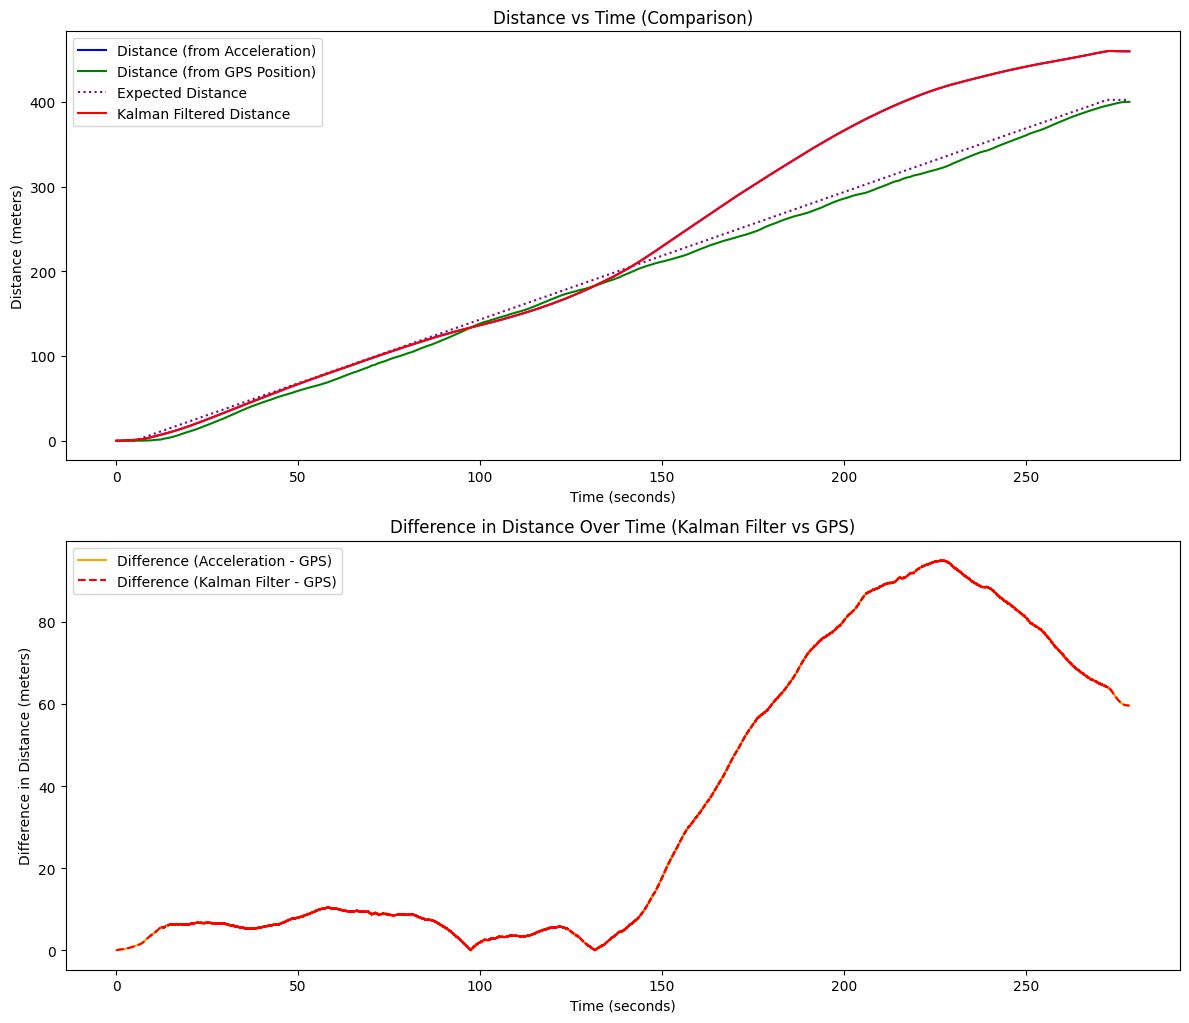

In [56]:

accel_data_x = merged_data['AccelerationX'] - merged_data['AccelerationX'].mean()
accel_data_y = merged_data['AccelerationY'] - merged_data['AccelerationY'].mean()

merged_data['Timestamp'] = merged_data['Timestamp'] - merged_data['Timestamp'].iloc[0]
time_seconds = merged_data['Timestamp'].astype(float).to_numpy()

velocity_x = np.zeros_like(time_seconds)
velocity_y = np.zeros_like(time_seconds)
distance_x = np.zeros_like(time_seconds)
distance_y = np.zeros_like(time_seconds)

for i in range(1, len(time_seconds)):
    dt = time_seconds[i] - time_seconds[i - 1]
    velocity_x[i] = velocity_x[i - 1] + (accel_data_x[i]) * dt
    velocity_y[i] = velocity_y[i - 1] + (accel_data_y[i]) * dt
    distance_x[i] = distance_x[i - 1] + (velocity_x[i]) * dt + 0.5 * accel_data_x[i] * dt * dt
    distance_y[i] = distance_y[i - 1] + (velocity_y[i]) * dt + 0.5 * accel_data_y[i] * dt * dt

distance_accel = np.sqrt(distance_x**2 + distance_y**2)
distance_position = np.sqrt(merged_data['Cumulative_X']**2 + merged_data['Cumulative_Y']**2).to_numpy()
distance_difference = np.abs(distance_accel - distance_position)

first_movement_index = np.argmax(distance_accel > 1)
last_movement_index = 27100
expected_distance = np.zeros_like(time_seconds)
if first_movement_index < len(time_seconds):
    expected_distance[first_movement_index:last_movement_index] = np.linspace(0, 1609 / 4, last_movement_index - first_movement_index)
    expected_distance[last_movement_index:] = 1609 / 4

kf = KalmanFilter(
    transition_matrices = [
        [1, 0, dt,  0],
        [0, 1,  0, dt],
        [0, 0,  1,  0], 
        [0, 0,  0,  1]  
    ],
    # x and y positions
    observation_matrices = [
        [1, 0, 0, 0],  
        [0, 1, 0, 0]   
    ],

    
    initial_state_mean=[distance_x[0], distance_y[0], 0, 0],
    initial_state_covariance=np.eye(4) * 100,
    observation_covariance=np.eye(2) * 10,
    transition_covariance=np.eye(4) * 1
)

observations = np.column_stack((distance_x, distance_y))
filtered_state_means, _ = kf.filter(observations)

filtered_distance_x = filtered_state_means[:, 0]
filtered_distance_y = filtered_state_means[:, 1]
filtered_distance = np.sqrt(filtered_distance_x**2 + filtered_distance_y**2)
kalman_gps_difference = np.abs(filtered_distance - distance_position)

plt.figure(figsize=(12, 15))

plt.subplot(3, 1, 1)
plt.plot(time_seconds, distance_accel, label="Distance (from Acceleration)", color='blue')
plt.plot(time_seconds, distance_position, label="Distance (from GPS Position)", color='green')
plt.plot(time_seconds, expected_distance, label="Expected Distance", color='purple', linestyle=':')
plt.plot(time_seconds, filtered_distance, label="Kalman Filtered Distance", color='red')
plt.xlabel("Time (seconds)")
plt.ylabel("Distance (meters)")
plt.title("Distance vs Time (Comparison)")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_seconds, distance_difference, label="Difference (Acceleration - GPS)", color='orange')
plt.xlabel("Time (seconds)")
plt.ylabel("Difference in Distance (meters)")
plt.title("Difference in Distance Over Time (Acceleration vs GPS)")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time_seconds, kalman_gps_difference, label="Difference (Kalman Filter - GPS)", color='red', linestyle='--')
plt.xlabel("Time (seconds)")
plt.ylabel("Difference in Distance (meters)")
plt.title("Difference in Distance Over Time (Kalman Filter vs GPS)")
plt.legend()

plt.tight_layout()
plt.show()


324.7725697235603


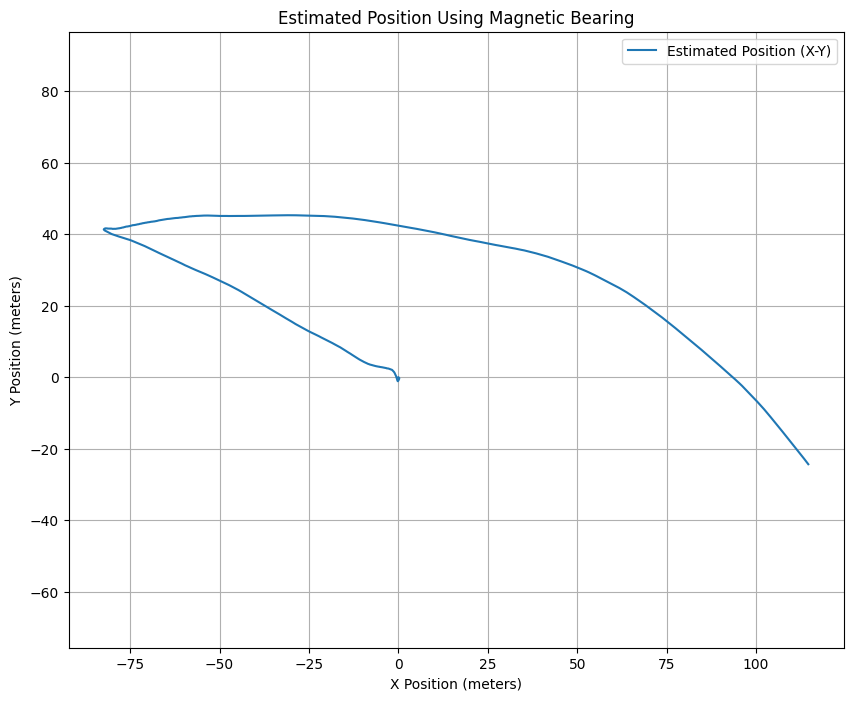

In [57]:
from scipy.spatial.transform import Rotation as R
# Function to load sensor data and synchronize by timestamp
def load_sensor_data(accel_file_path, gyro_file_path, compass_file_path):
    # Load each data file
    accel_data = pd.read_csv(accel_file_path)
    gyro_data = pd.read_csv(gyro_file_path)
    bearing_data = pd.read_csv(compass_file_path)

    #time in nanosecs
    accel_data['Timestamp'] = accel_data['time'] / 1e9 - accel_data['time'][0] / 1e9
    gyro_data['Timestamp'] = gyro_data['time'] / 1e9 - gyro_data['time'][0] / 1e9
    bearing_data['Timestamp'] = bearing_data['time'] / 1e9 - bearing_data['time'][0] / 1e9

    #merge
    sensor_data = pd.merge_asof(accel_data.sort_values('Timestamp'), gyro_data.sort_values('Timestamp'), 
                                on='Timestamp', suffixes=('_accel', '_gyro'), direction='nearest')
    sensor_data = pd.merge_asof(sensor_data.sort_values('Timestamp'), bearing_data.sort_values('Timestamp'), 
                                on='Timestamp', suffixes=('', '_bearing'), direction='nearest')
    return sensor_data

#sensor data
sensor_data = load_sensor_data(accel_file_path, gyro_file_path, compass_file_path)

velocity_x = np.zeros(len(sensor_data))
velocity_y = np.zeros(len(sensor_data))

#smaple period
time_diffs = sensor_data['Timestamp'].diff().fillna(0).to_numpy()

initial_val = yaw = sensor_data['magneticBearing'].iloc[0]
print(initial_val)


for i in range(1, len(sensor_data)):
    # dt = time_diffs[i]
    dt = time_seconds[i] - time_seconds[i - 1]

    yaw = sensor_data['magneticBearing'].iloc[i]-initial_val
    
    #kinematics
    velocity_x[i] = velocity_x[i - 1] + (accel_data_x[i]) * dt * (-1*np.sin(yaw*np.pi/180))
    velocity_y[i] = velocity_y[i - 1] + (accel_data_y[i]) * dt * (-1*np.cos(yaw*np.pi/180))
    distance_x[i] = distance_x[i - 1] + (velocity_x[i]) * dt + 0.5 * accel_data_x[i] * dt * dt * (-1*np.sin(yaw*np.pi/180))
    distance_y[i] = distance_y[i - 1] + (velocity_y[i]) * dt + 0.5 * accel_data_y[i] * dt * dt * (-1* np.cos(yaw*np.pi/180))

position_x = np.array(distance_x)
position_y = np.array(distance_y)

#plot
plt.figure(figsize=(10, 8))
plt.plot(position_x, position_y, label="Estimated Position (X-Y)")
plt.xlabel("X Position (meters)")
plt.ylabel("Y Position (meters)")
plt.title("Estimated Position Using Magnetic Bearing")
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()

Gyroscope Data Sample:
       Timestamp  seconds_elapsed     GyroZ     GyroY     GyroX
0  1.731518e+09         0.048228  0.296394 -0.005089  1.147182
1  1.731518e+09         0.058276  0.285630  0.060936  1.295083
2  1.731518e+09         0.068323  0.292469  0.172275  1.387913
3  1.731518e+09         0.078371  0.350869  0.025056  1.400237
4  1.731518e+09         0.088418  0.511493 -0.187797  1.422720
After Merging Accelerometer and Orientation Data:
 Index(['Timestamp', 'seconds_elapsed_accel', 'AccelerationZ', 'AccelerationY',
       'AccelerationX', 'seconds_elapsed_orientation', 'yaw', 'qx', 'qz',
       'roll', 'qw', 'qy', 'pitch'],
      dtype='object')
After Merging Gyroscope Data:
 Index(['Timestamp', 'seconds_elapsed_accel', 'AccelerationZ', 'AccelerationY',
       'AccelerationX', 'seconds_elapsed_orientation', 'yaw', 'qx', 'qz',
       'roll', 'qw', 'qy', 'pitch', 'seconds_elapsed', 'GyroZ', 'GyroY',
       'GyroX'],
      dtype='object')
GyroX successfully merged.
      Timest

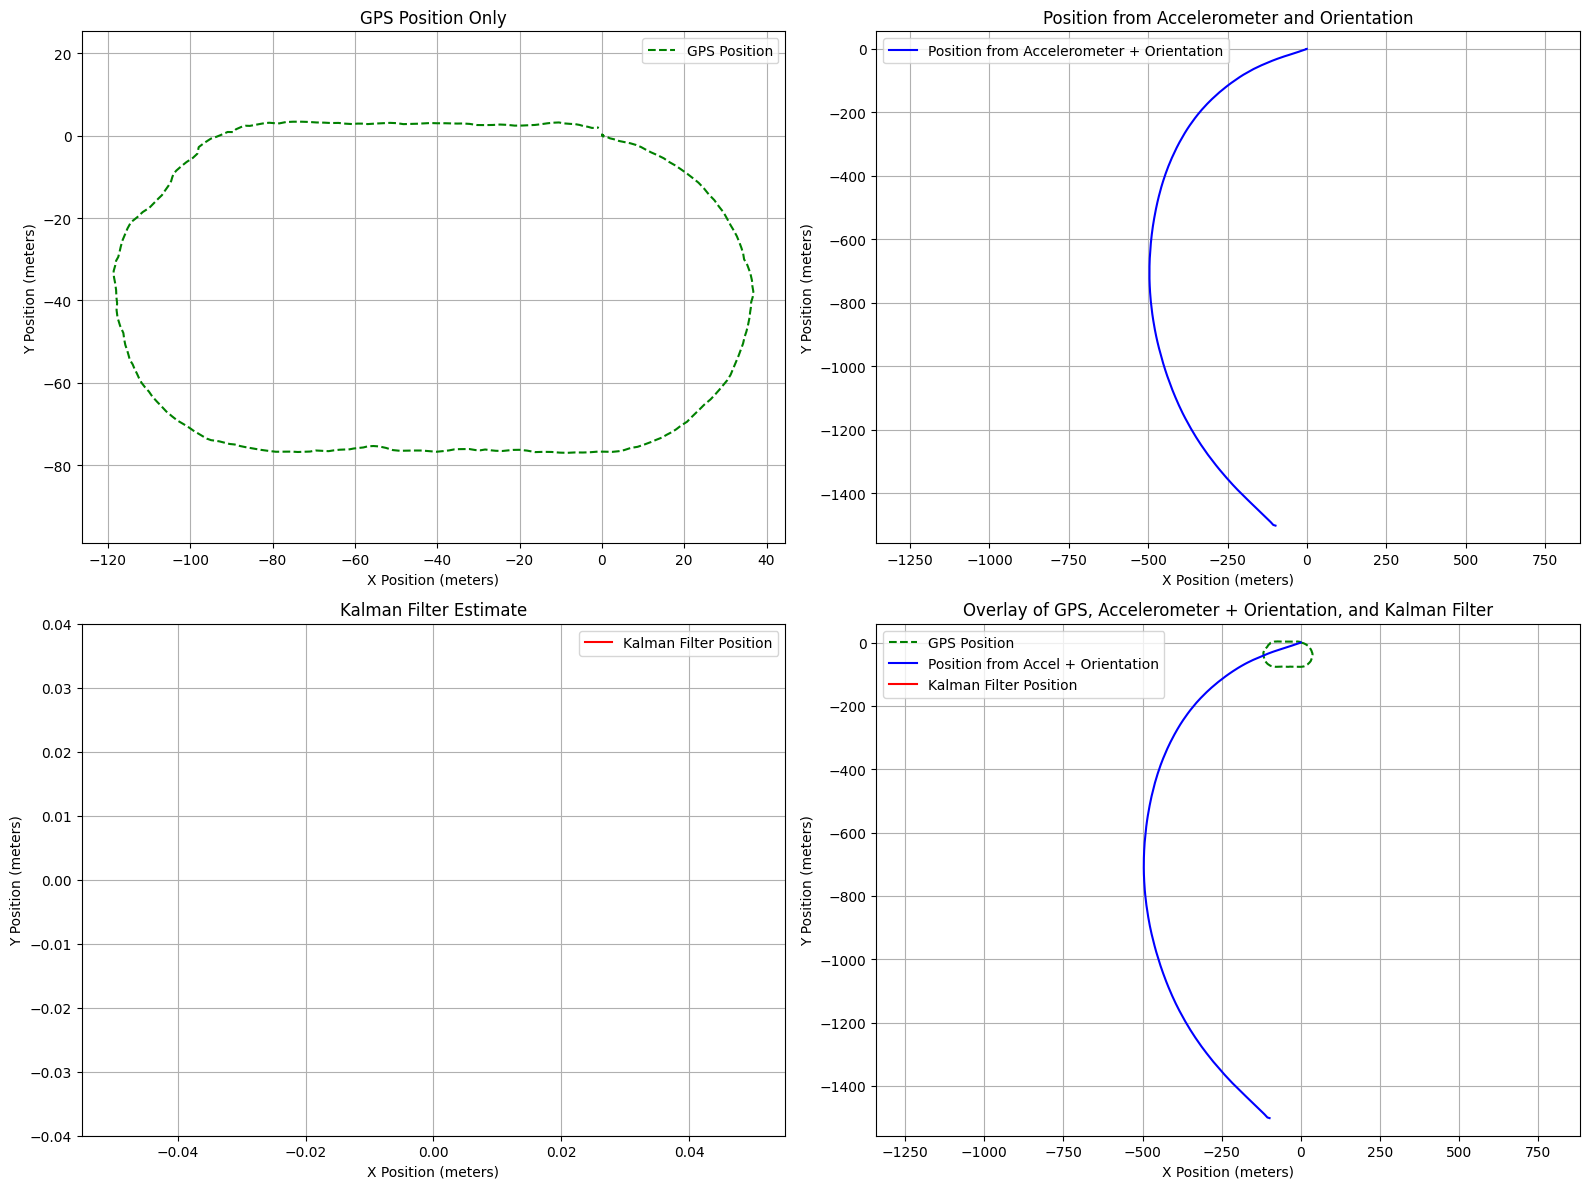

In [ ]:

def load_gps_data(gpx_file_path):
    R = 6371000 
    with open(gpx_file_path, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)

    gps_positions = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                gps_positions.append([point.latitude, point.longitude, point.elevation, point.time.timestamp()])
                
    gps_df = pd.DataFrame(gps_positions, columns=['Latitude', 'Longitude', 'Elevation', 'Timestamp'])
    gps_df['Timestamp'] = gps_df['Timestamp'] - gps_df['Timestamp'].iloc[0]  

    gps_df['X'] = np.cumsum(np.radians(gps_df['Latitude'].diff()) * R)
    gps_df['Y'] = np.cumsum(np.radians(gps_df['Longitude'].diff()) * R * np.cos(np.radians(gps_df['Latitude'])))
    return gps_df[['X', 'Y', 'Timestamp']]

def load_sensor_data(accel_file_path, orientation_file_path, gyro_file_path):
   
    accel_data = pd.read_csv(accel_file_path)
    accel_data.rename(columns={'time': 'Timestamp', 'z': 'AccelerationZ', 'y': 'AccelerationY', 'x': 'AccelerationX'}, inplace=True)
    accel_data['Timestamp'] = pd.to_numeric(accel_data['Timestamp'], errors='coerce')
    accel_data['Timestamp'] = accel_data['Timestamp'] / 1e9 
    accel_data = accel_data.dropna(subset=['Timestamp'])  

    accel_data['AccelerationX'] = pd.to_numeric(accel_data['AccelerationX'], errors='coerce')
    accel_data['AccelerationY'] = pd.to_numeric(accel_data['AccelerationY'], errors='coerce')
    accel_data['AccelerationZ'] = pd.to_numeric(accel_data['AccelerationZ'], errors='coerce')

    orientation_data = pd.read_csv(orientation_file_path)
    orientation_data.rename(columns={'time': 'Timestamp'}, inplace=True)
    orientation_data['Timestamp'] = pd.to_numeric(orientation_data['Timestamp'], errors='coerce')
    orientation_data['Timestamp'] = orientation_data['Timestamp'] / 1e9

    gyro_data = pd.read_csv(gyro_file_path)
    gyro_data.rename(columns={'time': 'Timestamp', 'z': 'GyroZ', 'y': 'GyroY', 'x': 'GyroX'}, inplace=True)
    gyro_data['Timestamp'] = pd.to_numeric(gyro_data['Timestamp'], errors='coerce')
    gyro_data['Timestamp'] = gyro_data['Timestamp'] / 1e9
    gyro_data = gyro_data.dropna(subset=['Timestamp']) 

    print("Gyroscope Data Sample:\n", gyro_data.head())

    sensor_data = pd.merge_asof(accel_data.sort_values('Timestamp'), orientation_data.sort_values('Timestamp'), 
                                on='Timestamp', suffixes=('_accel', '_orientation'), direction='nearest')

    #Check columns after first merge
    # print("After Merging Accelerometer and Orientation Data:\n", sensor_data.columns)
    #merge
    sensor_data = pd.merge_asof(sensor_data.sort_values('Timestamp'), gyro_data.sort_values('Timestamp'), 
                                on='Timestamp', suffixes=('', '_gyro'), direction='nearest')

 

    # merge based on time
    # sensor_data = pd.merge_asof(accel_data.sort_values('Timestamp'), orientation_data.sort_values('Timestamp'), 
    #                             on='Timestamp', suffixes=('_accel', '_orientation'), direction='nearest')
    # sensor_data = pd.merge_asof(sensor_data.sort_values('Timestamp'), gyro_data.sort_values('Timestamp'), 
    #                             on='Timestamp', suffixes=('', '_gyro'), direction='nearest')

    # # Apply filtering to accelerometer data
    # sensor_data['AccelerationX'] = low_pass_filter(sensor_data['AccelerationX'])
    # sensor_data['AccelerationY'] = low_pass_filter(sensor_data['AccelerationY'])
    # sensor_data['AccelerationZ'] = low_pass_filter(sensor_data['AccelerationZ'])

    print(sensor_data.head())  # Display the first few rows for verification

    return sensor_data



gps_df = load_gps_data(gpx_file_path)
sensor_data = load_sensor_data(accel_file_path, orientation_file_path, gyro_file_path)

position_x = [0]
position_y = [0]
velocity_x = np.zeros_like(time_seconds)
velocity_y = np.zeros_like(time_seconds)
distance_x = np.zeros_like(time_seconds)
distance_y = np.zeros_like(time_seconds)
global_accel_x = np.zeros_like(time_seconds)
global_accel_y = np.zeros_like(time_seconds)

time_diffs = sensor_data['Timestamp'].diff().fillna(0).to_numpy()

for i in range(1, len(sensor_data)):
    dt = time_diffs[i]
    
    qx = sensor_data['qx'].iloc[i]
    qy = sensor_data['qy'].iloc[i]
    qz = sensor_data['qz'].iloc[i]
    qw = sensor_data['qw'].iloc[i]
    orientation = R.from_quat([qx, qy, qz, qw]) 

    accel_vector = np.array([
        sensor_data['AccelerationX'].iloc[i],
        sensor_data['AccelerationY'].iloc[i],
        sensor_data['AccelerationZ'].iloc[i]
    ])
    global_accel_vector = orientation.apply(accel_vector)

    global_accel_x[i] = global_accel_vector[0]  # X component
    global_accel_y[i] = global_accel_vector[1]  # Y component
    # global_accel_z[i] = global_accel_vector[2]  # Y component

    # global_accel_x[i] = accel_data_x[i]
    # global_accel_y[i] = accel_data_y[i]

for i in range(1, len(sensor_data)):
    dt = time_diffs[i]
   
    # global_accel_vector[2] -= 9.81  # Assuming gravity acts in the global Z direction
    # Integrate acceleration to get velocity
    # velocity_x += global_accel_vector[0] * dt
    # velocity_y += global_accel_vector[1] * dt

    velocity_x[i] = velocity_x[i - 1] + 0.5 * (global_accel_x[i] + global_accel_x[i - 1]) * dt
    velocity_y[i] = velocity_y[i - 1] + 0.5 * (global_accel_y[i] + global_accel_y[i - 1]) * dt
    # velocity_x[i] = velocity_x[i - 1] + (global_accel_x[i]) * dt
    # velocity_y[i] = velocity_y[i - 1] + (global_accel_y[i]) * dt
    
    # Integrate velocity to get position (distance in each direction)
    # distance_x[i] = distance_x[i - 1] + 0.5 * (velocity_x[i] + velocity_x[i - 1]) * dt
    # distance_y[i] = distance_y[i - 1] + 0.5 * (velocity_y[i] + velocity_y[i - 1]) * dt
    distance_x[i] = distance_x[i - 1] + (velocity_x[i]) * dt + 0.5 * (global_accel_x[i] + global_accel_x[i - 1])/2 * dt**2
    distance_y[i] = distance_y[i - 1] + (velocity_y[i]) * dt + 0.5 * (global_accel_y[i] + global_accel_y[i - 1])/2 * dt**2

    # # Integrate velocity to get position
    # position_x.append(position_x[-1] + velocity_x * dt )
    # position_y.append(position_y[-1] + velocity_y * dt)

position_x = np.array(distance_x)
position_y = np.array(distance_y)

gps_positions = gps_df[['X', 'Y']].values

kf = KalmanFilter(
    transition_matrices=[[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]],
    observation_matrices=[[1, 0, 0, 0], [0, 1, 0, 0]],
    initial_state_mean=[gps_df['X'].iloc[0], gps_df['Y'].iloc[0], 0, 0],
    initial_state_covariance=np.eye(4),
    transition_covariance=np.eye(4) * 0.1,
    observation_covariance=np.eye(2) * 0.1
)

filtered_state_means, _ = kf.filter(gps_positions)
filtered_positions_x = filtered_state_means[:, 0]
filtered_positions_y = filtered_state_means[:, 1]

#plot
plt.figure(figsize=(16, 12))

#gps
plt.subplot(2, 2, 1)
plt.plot(gps_df['X'], gps_df['Y'], 'g--', label="GPS Position")
plt.xlabel("X Position (meters)")
plt.ylabel("Y Position (meters)")
plt.title("GPS Position Only")
plt.legend()
plt.grid()
plt.axis('equal')

# accelerometer
plt.subplot(2, 2, 2)
plt.plot(position_x, position_y, 'b-', label="Position from Accelerometer + Orientation")
plt.xlabel("X Position (meters)")
plt.ylabel("Y Position (meters)")
plt.title("Position from Accelerometer and Orientation")
plt.legend()
plt.grid()
plt.axis('equal')

#kf
plt.subplot(2, 2, 3)
plt.plot(filtered_positions_x, filtered_positions_y, 'r-', label="Kalman Filter Position")
plt.xlabel("X Position (meters)")
plt.ylabel("Y Position (meters)")
plt.title("Kalman Filter Estimate")
plt.legend()
plt.grid()
plt.axis('equal')

#all three
plt.subplot(2, 2, 4)
plt.plot(gps_df['X'], gps_df['Y'], 'g--', label="GPS Position")
plt.plot(position_x, position_y, 'b-', label="Position from Accel + Orientation")
plt.plot(filtered_positions_x, filtered_positions_y, 'r-', label="Kalman Filter Position")
plt.xlabel("X Position (meters)")
plt.ylabel("Y Position (meters)")
plt.title("Overlay of GPS, Accelerometer + Orientation, and Kalman Filter")
plt.legend()
plt.grid()
plt.axis('equal')

plt.tight_layout()
plt.show()


Gyroscope Data Sample:
       Timestamp  seconds_elapsed  magneticBearing
0  1.731518e+09         0.048228       324.772570
1  1.731518e+09         0.058276       318.924282
2  1.731518e+09         0.068323       313.121503
3  1.731518e+09         0.078371       309.342547
4  1.731518e+09         0.088418       303.447011
      Timestamp  seconds_elapsed_accel  AccelerationZ  AccelerationY  \
0  1.731518e+09               0.048228      -0.483313       0.403148   
1  1.731518e+09               0.058276      -0.628412       0.267351   
2  1.731518e+09               0.068323      -0.339378       0.488742   
3  1.731518e+09               0.078371       0.028413       1.013983   
4  1.731518e+09               0.088418       0.524244       1.405467   

   AccelerationX  seconds_elapsed_orientation         z         y         x  \
0      -0.055416                     0.048228  0.296394 -0.005089  1.147182   
1       0.095232                     0.058276  0.285630  0.060936  1.295083   
2     

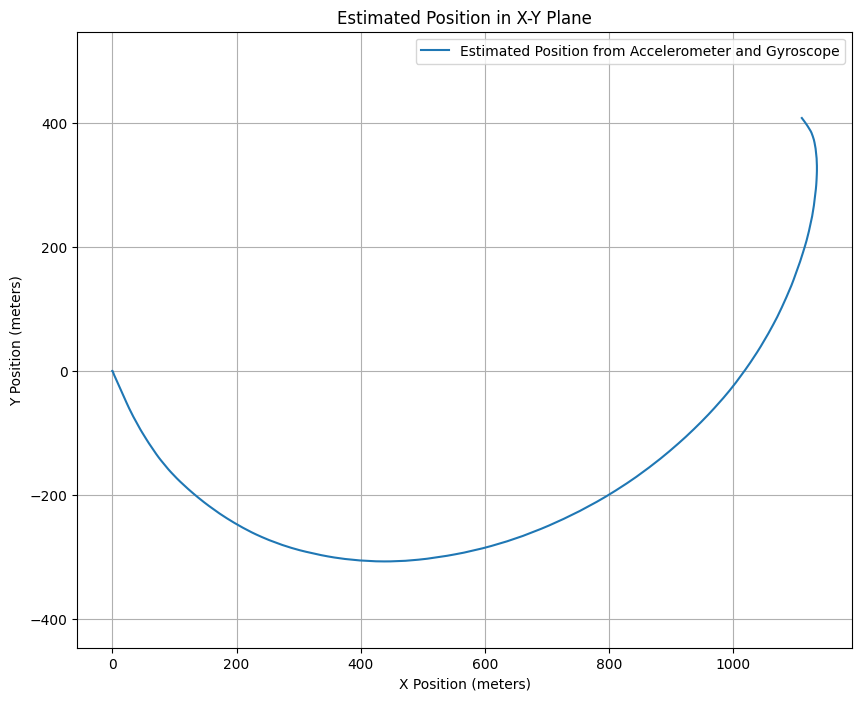

KeyError: 'x_gyro'

<Figure size 1200x600 with 0 Axes>

In [59]:
from scipy.spatial.transform import Rotation as R
from scipy.integrate import cumtrapz

# Function to load accelerometer, orientation, and gyroscope data
def load_sensor_data(accel_file_path, orientation_file_path, gyro_file_path):
    # Load accelerometer data
    accel_data = pd.read_csv(accel_file_path)
    accel_data.rename(columns={'time': 'Timestamp', 'z': 'AccelerationZ', 'y': 'AccelerationY', 'x': 'AccelerationX'}, inplace=True)
    accel_data['Timestamp'] = pd.to_numeric(accel_data['Timestamp'], errors='coerce')
    accel_data['Timestamp'] = accel_data['Timestamp'] / 1e9 
    accel_data = accel_data.dropna(subset=['Timestamp'])  


    accel_data['AccelerationX'] = pd.to_numeric(accel_data['AccelerationX'], errors='coerce')
    accel_data['AccelerationY'] = pd.to_numeric(accel_data['AccelerationY'], errors='coerce')
    accel_data['AccelerationZ'] = pd.to_numeric(accel_data['AccelerationZ'], errors='coerce')

    orientation_data = pd.read_csv(orientation_file_path)
    orientation_data.rename(columns={'time': 'Timestamp'}, inplace=True)
    orientation_data['Timestamp'] = pd.to_numeric(orientation_data['Timestamp'], errors='coerce')
    orientation_data['Timestamp'] = orientation_data['Timestamp'] / 1e9

    gyro_data = pd.read_csv(gyro_file_path)
    gyro_data.rename(columns={'time': 'Timestamp', 'z': 'GyroZ', 'y': 'GyroY', 'x': 'GyroX'}, inplace=True)
    gyro_data['Timestamp'] = pd.to_numeric(gyro_data['Timestamp'], errors='coerce')
    gyro_data['Timestamp'] = gyro_data['Timestamp'] / 1e9
    gyro_data = gyro_data.dropna(subset=['Timestamp'])  # Drop rows with NaT values in the Timestamp column


    print("Gyroscope Data Sample:\n", gyro_data.head())

    sensor_data = pd.merge_asof(accel_data.sort_values('Timestamp'), orientation_data.sort_values('Timestamp'), 
                                on='Timestamp', suffixes=('_accel', '_orientation'), direction='nearest')

    sensor_data = pd.merge_asof(sensor_data.sort_values('Timestamp'), gyro_data.sort_values('Timestamp'), 
                                on='Timestamp', suffixes=('', '_gyro'), direction='nearest')


    # # Merge dataframes based on nearest timestamps
    # sensor_data = pd.merge_asof(accel_data.sort_values('Timestamp'), orientation_data.sort_values('Timestamp'), 
    #                             on='Timestamp', suffixes=('_accel', '_orientation'), direction='nearest')
    # sensor_data = pd.merge_asof(sensor_data.sort_values('Timestamp'), gyro_data.sort_values('Timestamp'), 
    #                             on='Timestamp', suffixes=('', '_gyro'), direction='nearest')

    # # Apply filtering to accelerometer data
    # sensor_data['AccelerationX'] = low_pass_filter(sensor_data['AccelerationX'])
    # sensor_data['AccelerationY'] = low_pass_filter(sensor_data['AccelerationY'])
    # sensor_data['AccelerationZ'] = low_pass_filter(sensor_data['AccelerationZ'])

    print(sensor_data.head())  # Display the first few rows for verification

    return sensor_data


# Initialize position, velocity, and timestep arrays
position_x = [0]
position_y = [0]
velocity_x = 0
velocity_y = 0
time_diffs = sensor_data['Timestamp'].diff().fillna(0).to_numpy()

gyroscope_columns = ['x', 'y', 'z']

sensor_data = load_sensor_data(accel_file_path, gyro_file_path, compass_file_path)

#init
position_x = [0]
position_y = [0]
velocity_x = 0
velocity_y = 0
orientation_angle = 0

#dt
time_diffs = sensor_data['Timestamp'].diff().fillna(0).to_numpy()

#loop thru to compute orientation, transform acceleration, and integrate for distance
for i in range(1, len(sensor_data)):
    dt = time_diffs[i]
    
    #update orientation
    yaw_rate = sensor_data['z'].iloc[i]
    orientation_angle += yaw_rate * dt

    #rotation matrix??
    rotation = R.from_euler('z', orientation_angle).as_matrix()[:2, :2]
    
    #apply rotation
    accel_vector = np.array([sensor_data['AccelerationX'].iloc[i], sensor_data['AccelerationY'].iloc[i]])
    global_accel_vector = rotation.dot(accel_vector)
    
    #kinematics
    velocity_x += global_accel_vector[0] * dt
    velocity_y += global_accel_vector[1] * dt
    position_x.append(position_x[-1] + velocity_x * dt)
    position_y.append(position_y[-1] + velocity_y * dt)

#plot estimated path
plt.figure(figsize=(10, 8))
plt.plot(position_x, position_y, label="Estimated Position from Accelerometer and Gyroscope")
plt.xlabel("X Position (meters)")
plt.ylabel("Y Position (meters)")
plt.title("Estimated Position in X-Y Plane")
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()

#gyroscope
plt.figure(figsize=(12, 6))
plt.plot(sensor_data['Timestamp'], sensor_data['x_gyro'], label='Gyroscope X')
plt.plot(sensor_data['Timestamp'], sensor_data['y_gyro'], label='Gyroscope Y')
plt.plot(sensor_data['Timestamp'], sensor_data['z_gyro'], label='Gyroscope Z')
plt.title('Device Orientation Over Time (Gyroscope Data)')
plt.xlabel('Time (seconds)')
plt.ylabel('Angular Velocity')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from scipy.spatial.transform import Rotation as R
from scipy.integrate import cumtrapz

position_x = [0]
position_y = [0]
velocity_x = 0
velocity_y = 0
time_diffs = sensor_data['Timestamp'].diff().fillna(0).to_numpy()
print(sensor_data.columns)

gyroscope_columns = ['x', 'y', 'z']

if all(col in sensor_data.columns for col in gyroscope_columns):
    for i in range(1, len(sensor_data)):
        dt = time_diffs[i]
        print(sensor_data.columns)
        gyro_vector = sensor_data[gyroscope_columns].iloc[i] * dt
        rotation = R.from_euler('xyz', gyro_vector).as_matrix()[:2, :2]
else:
    print("The gyroscope data columns were not found in the expected format.")

sensor_data = load_sensor_data(accel_file_path, gyro_file_path, compass_file_path)

position_x = [0]
position_y = [0]
velocity_x = 0
velocity_y = 0
orientation_angle = 0

time_diffs = sensor_data['Timestamp'].diff().fillna(0).to_numpy()

for i in range(1, len(sensor_data)):
    dt = time_diffs[i]
    yaw_rate = sensor_data['z'].iloc[i]
    orientation_angle += yaw_rate * dt
    rotation = R.from_euler('z', orientation_angle).as_matrix()[:2, :2]
    accel_vector = np.array([sensor_data['AccelerationX'].iloc[i], sensor_data['AccelerationY'].iloc[i]])
    global_accel_vector = rotation.dot(accel_vector)
    velocity_x += global_accel_vector[0] * dt
    velocity_y += global_accel_vector[1] * dt
    position_x.append(position_x[-1] + velocity_x * dt)
    position_y.append(position_y[-1] + velocity_y * dt)

plt.figure(figsize=(12, 6))
plt.plot(sensor_data['Timestamp'], sensor_data['x_gyro'], label='Gyroscope X')
plt.plot(sensor_data['Timestamp'], sensor_data['y_gyro'], label='Gyroscope Y')
plt.plot(sensor_data['Timestamp'], sensor_data['z_gyro'], label='Gyroscope Z')
plt.title('Device Orientation Over Time (Gyroscope Data)')
plt.xlabel('Time (seconds)')
plt.ylabel('Angular Velocity')
plt.legend()
plt.grid(True)
plt.show()


Index(['time_accel', 'seconds_elapsed_accel', 'z_accel', 'y_accel', 'x_accel',
       'Timestamp', 'time_gyro', 'seconds_elapsed_gyro', 'z_gyro', 'y_gyro',
       'x_gyro', 'time', 'seconds_elapsed', 'magneticBearing'],
      dtype='object')
The gyroscope data columns were not found in the expected format.


KeyError: 'z'